In [123]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn_crfsuite import CRF
from sklearn.metrics import classification_report
import pandas as pd
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings('ignore')
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense
from tensorflow.keras.layers import TimeDistributed, SpatialDropout1D, Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from livelossplot.tf_keras import PlotLossesCallback

In [94]:
# Read the data from the CSV file
data = pd.read_csv("ner_dataset.csv",encoding='latin-1')

In [95]:
data.Tag.unique()

array(['O', 'B-geo', 'B-gpe', 'B-per', 'I-geo', 'B-org', 'I-org', 'B-tim',
       'B-art', 'I-art', 'I-per', 'I-gpe', 'I-tim', 'B-nat', 'B-eve',
       'I-eve', 'I-nat'], dtype=object)

In [96]:
#Looking for null values
print(data.isnull().sum())

Sentence #    1000616
Word                0
POS                 0
Tag                 0
dtype: int64


In [152]:
#Looking for null values
print(data.duplicated().sum())

953668


In [97]:
print("Unique Words in corpus:",data['Word'].nunique())
print("Unique Tag in corpus:",data['Tag'].nunique())

Unique Words in corpus: 35178
Unique Tag in corpus: 17


In [98]:
#Filling Null Values
# data = data.fillna(method='ffill')

In [99]:
## Stroring unique values 
num_words, num_tags = data['Word'].nunique() , data['Tag'].nunique()
num_words, num_tags

(35178, 17)

## Data Preprocessing

In [100]:
# Feature extraction function
def word2features(sent, i):
    word = sent.iloc[i]['Word']
    
    features = {
        'bias': 1.0,
        'word.lower()': word.lower(),
        'word[-3:]': word[-3:],
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
    }
    
    if i > 0:
        word1 = sent.iloc[i-1]['Word']
        features.update({
            '-1:word.lower()': word1.lower(),
            '-1:word.istitle()': word1.istitle(),
            '-1:word.isupper()': word1.isupper(),
        })
    else:
        features['BOS'] = True  # Beginning of sentence
    
    if i < len(sent)-1:
        word1 = sent.iloc[i+1]['Word']
        features.update({
            '+1:word.lower()': word1.lower(),
            '+1:word.istitle()': word1.istitle(),
            '+1:word.isupper()': word1.isupper(),
        })
    else:
        features['EOS'] = True  # End of sentence
    
    return features



In [101]:
# Split the data into train, validation, and test sets
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.2, random_state=42)


In [102]:
# Convert data to a format suitable for CRF
def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

def sent2labels(sent):
    return list(sent['Tag'])


In [103]:
# Prepare the training and validation data
X_train = [sent2features(sent) for _, sent in train_data.groupby('Sentence #')]
y_train = [sent2labels(sent) for _, sent in train_data.groupby('Sentence #')]

X_val = [sent2features(sent) for _, sent in val_data.groupby('Sentence #')]
y_val = [sent2labels(sent) for _, sent in val_data.groupby('Sentence #')]

In [104]:
# Train the CRF model
crf = CRF(algorithm='lbfgs', c1=0.1, c2=0.1, max_iterations=100, all_possible_transitions=True)
crf.fit(X_train, y_train)

# Make predictions on the validation set
y_pred = crf.predict(X_val)

In [108]:
# Evaluate the improved model
print("BaseLine Model Evaluation on Validation Data:")
print("Accuracy : ",np.round(accuracy_score(y_val,y_pred)*100,2),"%")
print(classification_report(y_val, y_pred))

BaseLine Model Evaluation on Validation Data:
Accuracy :  92.44 %
              precision    recall  f1-score   support

       B-art       0.00      0.00      0.00         1
       B-eve       0.00      0.00      0.00         2
       B-geo       0.74      0.86      0.79       543
       B-gpe       0.93      0.89      0.91       494
       B-nat       1.00      0.50      0.67         2
       B-org       0.72      0.50      0.59       442
       B-per       0.87      0.79      0.83       636
       B-tim       0.97      0.72      0.82        92
           O       0.96      0.99      0.97      5475

    accuracy                           0.92      7687
   macro avg       0.69      0.58      0.62      7687
weighted avg       0.92      0.92      0.92      7687



In [107]:
### On Test Data 
X_test = [sent2features(sent) for _, sent in test_data.groupby('Sentence #')]
y_test = [sent2labels(sent) for _, sent in test_data.groupby('Sentence #')]

# Make predictions on the validation set
y_pred_test = crf.predict(X_test)

# Evaluate the improved model
print("BaseLine Model Evaluation on Test Data:")
print("Accuracy : ",np.round(accuracy_score(y_test,y_pred_test)*100,2),"%")
print(classification_report(y_test, y_pred_test))

BaseLine Model Evaluation on Test Data:
Accuracy :  93.13 %
              precision    recall  f1-score   support

       B-art       1.00      0.12      0.22         8
       B-eve       0.00      0.00      0.00         3
       B-geo       0.76      0.88      0.82       724
       B-gpe       0.94      0.91      0.93       576
       B-nat       0.50      0.50      0.50         2
       B-org       0.72      0.52      0.61       539
       B-per       0.89      0.84      0.86       812
       B-tim       0.91      0.69      0.78       105
           O       0.97      0.99      0.98      6970

    accuracy                           0.93      9739
   macro avg       0.74      0.61      0.63      9739
weighted avg       0.93      0.93      0.93      9739



### Improving Performance

In [136]:
#Creating a class to get data in desired formate. i.e. Word,POS,Tag
class SentenceGetter(object):
  def __init__(self,data):
    self.n_sent = 1 #counter
    self.data = data
    agg_func = lambda s:[(w,t) for w,t in zip(s['Word'].tolist(),s['Tag'].tolist())]
    self.grouped = self.data.groupby("Sentence #").apply(agg_func)
    self.sentences = [s for s in self.grouped]

In [137]:
getter = SentenceGetter(data)
sentences = getter.sentences

In [138]:
# Mapping b/w tags and sentences
word2idx =  {w : i+1 for i,w in enumerate(list(set(data['Word'].values)))}
tag2idx  =  {t : i for i,t in enumerate(list(set(data['Tag'].values)))}

In [140]:
max_len = 50

X = [[word2idx[w[0]] for w in s]for s in sentences]
X = pad_sequences(maxlen = max_len , sequences =X, padding='post', value =num_words-1)

y = [[tag2idx[w[1]] for w in s]for s in sentences]
y = pad_sequences(maxlen = max_len , sequences =y, padding='post', value =tag2idx["O"])
y = [to_categorical(i, num_classes=num_tags) for i in y]

In [141]:

x_train,x_test,y_train,y_test = train_test_split(X,y, test_size=0.1, random_state=1)

### Build a Bidirectional LSTM Model

In [142]:

input_word = Input(shape = (max_len,))
model = Embedding(input_dim=num_words,output_dim=max_len)(input_word)
model = SpatialDropout1D(0.1)(model)
model = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))(model)
out = TimeDistributed(Dense(num_tags,activation='softmax'))(model)
model = Model(input_word,out)
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_2 (Embedding)         │ (None, 50, 50)         │     1,758,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_1             │ (None, 50, 50)         │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 50, 200)        │       120,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 50, 17)         │         3,417 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,883,117 (7.18 MB)

 Trainable params: 1,883,117 (7.18 MB)

 Non-trainable params: 0 (0.00 B)

In [143]:
model.compile(optimizer="adam",loss='categorical_crossentropy',metrics=['accuracy'])

### Train the model

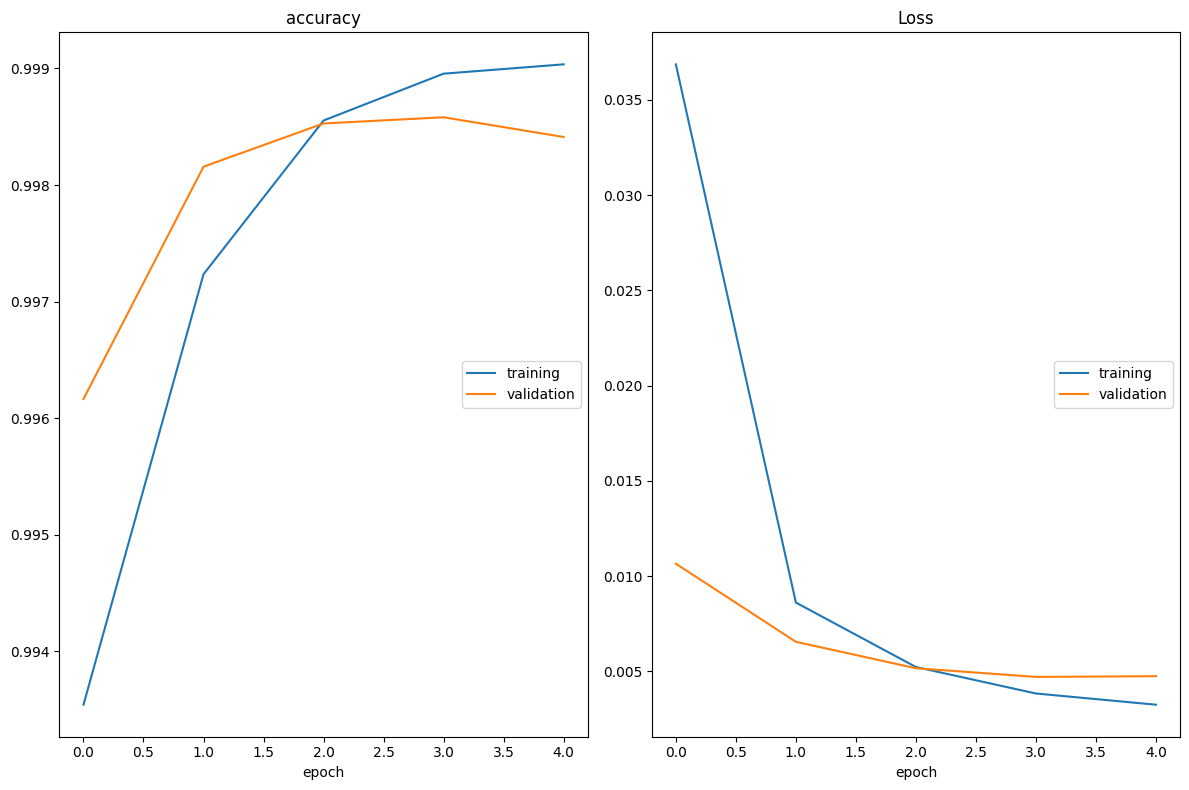

accuracy
	training         	 (min:    0.994, max:    0.999, cur:    0.999)
	validation       	 (min:    0.996, max:    0.999, cur:    0.998)
Loss
	training         	 (min:    0.003, max:    0.037, cur:    0.003)
	validation       	 (min:    0.005, max:    0.011, cur:    0.005)
540/540 ━━━━━━━━━━━━━━━━━━━━ 144s 267ms/step - accuracy: 0.9990 - loss: 0.0033 - val_accuracy: 0.9984 - val_loss: 0.0047


In [144]:
early_stopping = EarlyStopping(monitor='val_accuracy',patience=1,verbose=0,mode='max',restore_best_weights=False)
callbacks = [PlotLossesCallback(),early_stopping]

history = model.fit(
    x_train,np.array(y_train),
    validation_split = 0.2,
    batch_size = 64,
    epochs = 5,
    verbose = 1,
    callbacks=callbacks
)

In [150]:
test_evaluation = model.evaluate(x_test, np.array(y_test))

150/150 ━━━━━━━━━━━━━━━━━━━━ 7s 48ms/step - accuracy: 0.9983 - loss: 0.0049


In [151]:
print("Evaluation on Test Data:")
print("Improved accuracy on Test Data:",np.round(test_evaluation[1]*100,2),"%")

Evaluation on Test Data:
Improved accuracy on Test Data: 99.84 %
